# How to detect marine heatwave based on observational dataset

The marine heatwaves are anomalous warm water over the ocean. 
To detect the warm ocean water, sea surface temperature (SST) is usually used to define if there is any marine heatwave event. 

The following example is following the paper [Jacox et al., 2022](http://doi.org/10.1038/s41586-022-04573-9)


In [1]:
import warnings
import datetime
import xarray as xr
import numpy as np
# from dask.distributed import Client


In [5]:
opendap_mon_url = "https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.mon.mean.nc"

In [6]:
ds_mon = xr.open_dataset(opendap_mon_url, engine='pydap', chunks={'time':12,'lon':-1,'lat':-1})

In [7]:
climo_start_yr = 2010             # determine the climatology/linear trend start year
climo_end_yr = 2020               # determine the climatology/linear trend end year

ds_mon_crop = ds_mon.where((ds_mon['time.year']>=climo_start_yr)&
                           (ds_mon['time.year']<=climo_end_yr),drop=True)

In [8]:
ds_mon_crop

<xarray.Dataset>
Dimensions:  (time: 360, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1991-01-01 1991-02-01 ... 2020-12-01
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(8, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.5
    title:                           NOAA/NCEI 1/4 Degree Daily Optimum Inter...
    institution:                     NOAA/National Centers for Environmental ...
    source:                          NOAA/NCEI https://www.ncei.noaa.gov/data...
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    dataset_title:                   NOAA Daily Optimum Interpolation Sea Sur...
    version:                         Version 2.1
    comment:                         Reynolds, et al.(2007) Daily High-Resolu...
    _NCProperties:                   version=2,netcdf=4.7.0,hdf5=1.10.5,
    DODS_EXTRA.Unlimited_Dimension:  time

In [9]:
ds_mon_climo = ds_mon_crop.groupby('time.month').mean()
ds_mon_anom = (ds_mon_crop.groupby('time.month')-ds_mon_climo).compute()

In [10]:
ds_mon_anom.sst

<xarray.DataArray 'sst' (time: 360, lat: 720, lon: 1440)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.00589252,  0.00719368,  0.00772047, ...,  0.00786018,
          0.00761271,  0.00603223],
        [ 0.00717211,  0.0098387 ,  0.01060212, ...,  0.01106441,
          0.01078486,  0.0075376 ],
        [ 0.01319349,  0.01299989,  0.01282787, ...,  0.01218283,
          0.0125376 ,  0.01293528]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 0.06112218,  0.04438877,  0.03573334, ...,  0.01137769,
          0.02317786,  0.04613316],
        [ 0.02836668, -0.00721121, -0.0228554 , ..., -0.03271115,
         -0.0209223 ,  0.01328886],
        [-0.07261121, -0.07261121, -0.05686677, ..., -0.06292236,
         -0.07261121, -0.07261121]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.03390336,  0.01902151,  0.01090312, ...,  0.00548387,
          0.01113987,  0.02648389],
        [ 0.01508617, -0.01265585, -0.02816129, ..., -0.02589262,
         -0.02017212,  0.00625813],
        [-0.05079567, -0.05079567, -0.0508064 , ..., -0.05078495,
         -0.05078495, -0.05078495]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1991-01-01 1991-02-01 ... 2020-12-01
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [11]:
########## Functions ######### 
# Function to calculate the 3 month rolling Quantile
def mj_3mon_quantile(da_data, mhw_threshold=90.):
    
    da_data_quantile = xr.DataArray(coords={'lon':da_data.lon,
                                            'lat':da_data.lat,
                                            'month':np.arange(1,13)},
                                    dims = ['month','lat','lon'])

    for i in range(1,13):
        if i == 1:
            mon_range = [12,1,2]
        elif i == 12 :
            mon_range = [11,12,1]
        else:
            mon_range = [i-1,i,i+1]

        da_data_quantile[i-1,:,:] = (da_data
                                 .where((da_data['time.month'] == mon_range[0])|
                                        (da_data['time.month'] == mon_range[1])|
                                        (da_data['time.month'] == mon_range[2]),drop=True)
                                 .quantile(mhw_threshold*0.01, dim = 'time', skipna = True))

    return da_data_quantile


In [12]:
%time da_mon_quantile = mj_3mon_quantile(ds_mon_anom.sst, mhw_threshold=90)

CPU times: user 9min 27s, sys: 21.8 s, total: 9min 48s
Wall time: 9min 46s


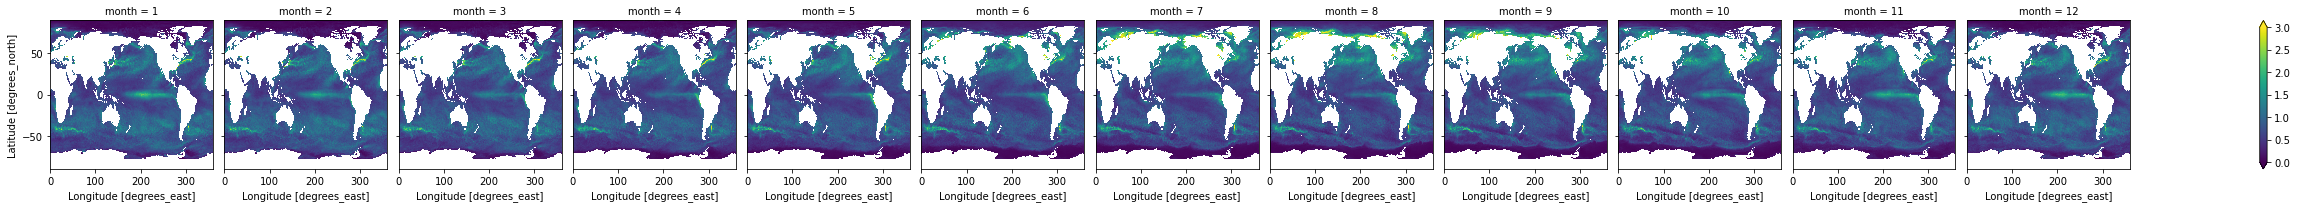

In [13]:
da_mon_quantile.plot(col='month',vmin=0,vmax=3)

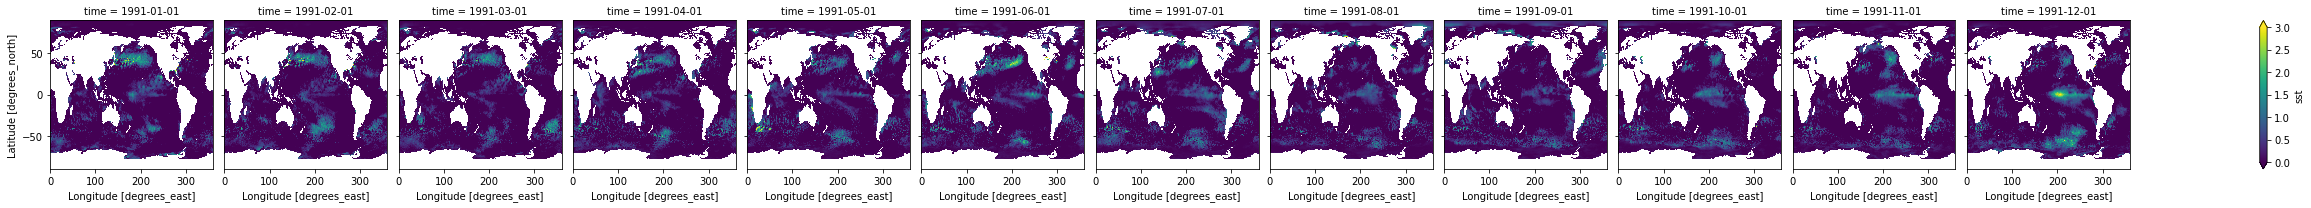

In [14]:
ds_mon_anom.sst.isel(time=slice(0,12)).plot(col='time',vmin=0,vmax=3)

In [15]:
da_mhw = ds_mon_anom.sst.where(ds_mon_anom.sst.groupby('time.month')>da_mon_quantile)

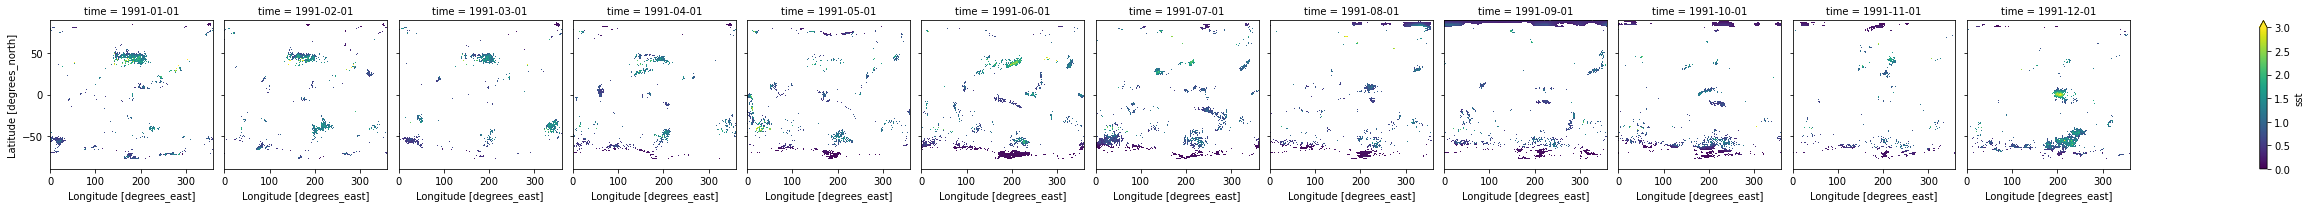

In [16]:
da_mhw.isel(time=slice(0,12)).plot(col='time',vmin=0,vmax=3)